# Pump It Up: Data Mining the Water Table (Competition)
## DrivenData.org Practice Competition

**Can you predict which water pumps are faulty?**

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

#### Reference:
DrivenData. (2015). Pump it Up: Data Mining the Water Table. Retrieved July 17, 2024 from https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table.

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 19.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.metrics import classification_report, confusion_matrix, \
                            ConfusionMatrixDisplay, accuracy_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load data
train_label = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/train_labels.csv')
train_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/train_values.csv')
test_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/test_values.csv')
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/SubmissionFormat.csv')

Mounted at /content/drive


In [ ]:
# Joining `status_group` to other features on column `id`
train_df = pd.merge(train_features, train_label, on='id')
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Preprocessing (before train/test split)
- Change `region_code`, `district_code`, & `construction_year` to 'object' type
- Convert `date_recorded` into year, month, & day features
- Drop `num_private`, `recorded_by`, `date_recorded`, & `id` features
- Convert categorical columns to lower case

# Preprocessing (after train/test split)
- Fill missing values with `unknown`


In [ ]:
# Convert 'region_code' and 'district_code' to type 'object'
train_df['region_code'] = train_df['region_code'].astype('object')
train_df['district_code'] = train_df['district_code'].astype('object')
train_df['construction_year'] = train_df['construction_year'].astype('object')

test_features['region_code'] = test_features['region_code'].astype('object')
test_features['district_code'] = test_features['district_code'].astype('object')
test_features['construction_year'] = test_features['construction_year'].astype('object')

# Convert 'date_recorded' into year, month, day columns
train_df['date_recorded'] = pd.to_datetime(train_df['date_recorded'])
train_df['year_recorded'] = train_df['date_recorded'].dt.year
train_df['month_recorded'] = train_df['date_recorded'].dt.month
train_df['day_recorded'] = train_df['date_recorded'].dt.day

test_features['date_recorded'] = pd.to_datetime(test_features['date_recorded'])
test_features['year_recorded'] = test_features['date_recorded'].dt.year
test_features['month_recorded'] = test_features['date_recorded'].dt.month
test_features['day_recorded'] = test_features['date_recorded'].dt.day

# Log Transform 'amount_tsh' and 'population'
train_df['amount_tsh_log'] = np.log1p(train_df['amount_tsh'])
train_df['population_log'] = np.log1p(train_df['population'])
test_features['amount_tsh_log'] = np.log1p(test_features['amount_tsh'])
test_features['population_log'] = np.log1p(test_features['population'])

# Drop unneccessary columns
train_df = train_df.drop(
    columns=[
        'num_private', 'recorded_by',               # irrelevant
        'date_recorded',                            # new features made
        'amount_tsh', 'population',                 # log transformed
])

test_features = test_features.drop(
    columns=[
        'id',
        'num_private', 'recorded_by',               # irrelevant
        'date_recorded',                            # new features made
        'amount_tsh', 'population',                 # log transformed
])

In [ ]:
X = train_df.drop(columns=['status_group','id'], axis=1)
y = train_df['status_group']

# Split train_df into 80% train and 20% test, stratified by y ('status_group')
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42)

In [ ]:
# Impute 0 values in 'longitude' and 'latitude'
region_medians = X_train.groupby('region_code')[['longitude', 'latitude']].median()

#Impute missing values in the training set where longitude or latitude is ~0
X_train['longitude'] = X_train.apply(
    lambda row: region_medians.loc[row['region_code'], 'longitude'] \
    if row['longitude'] == 0 else row['longitude'], axis=1
)

X_train['latitude'] = X_train.apply(
    lambda row: region_medians.loc[row['region_code'], 'latitude'] \
    if row['latitude'] == -2.000000e-08 else row['latitude'], axis=1
)

# Apply the same imputation to the test set using medians from the training set
X_test['longitude'] = X_test.apply(
    lambda row: region_medians.loc[row['region_code'], 'longitude'] \
    if row['longitude'] == 0 else row['longitude'], axis=1
)
X_test['latitude'] = X_test.apply(
    lambda row: region_medians.loc[row['region_code'], 'latitude'] \
    if row['latitude'] == -2.000000e-08 else row['latitude'], axis=1
)

# Apply the same imputation to the test set using medians from the training set
test_features['longitude'] = test_features.apply(
    lambda row: region_medians.loc[row['region_code'], 'longitude'] \
    if row['longitude'] == 0 else row['longitude'], axis=1
)
test_features['latitude'] = test_features.apply(
    lambda row: region_medians.loc[row['region_code'], 'latitude'] \
    if row['latitude'] == -2.000000e-08 else row['latitude'], axis=1
)

In [ ]:
# Fill Categorical Columns with missing values in X_train, X_test, and test_features with 'nan'
categorical_columns = X.select_dtypes(include=['object']).columns

X_train[categorical_columns] = X_train[categorical_columns].fillna('nan')
X_test[categorical_columns] = X_test[categorical_columns].fillna('nan')
test_features[categorical_columns] = test_features[categorical_columns].fillna('nan')

In [ ]:
%%time
# Replace infrequent columns in 'funder', 'installer', and 'wpt_name'
# if less than threshold. Can adjust value in future iterations.

# Define the columns to be transformed
columns_to_transform = [
    'funder',
    'installer',
    'wpt_name',
    'subvillage',
    'scheme_name',
    'ward'
]

# Function to replace infrequent categories with 'Other'
def replace_infrequent_categories(df, columns, threshold=30):
    for column in columns:
        value_counts = df[column].value_counts()
        to_replace = value_counts[value_counts <= threshold].index
        df[column] = df[column].replace(to_replace, 'INFREQUENT')
    return df

# Apply the function to X_train, X_test, and test_features
X_train = replace_infrequent_categories(X_train, columns_to_transform)
X_test = replace_infrequent_categories(X_test, columns_to_transform)
test_features = replace_infrequent_categories(test_features, columns_to_transform)

CPU times: user 1min 58s, sys: 120 ms, total: 1min 58s
Wall time: 1min 58s


# Random Forest

In [ ]:
# Threshold for OneHotEncoding
threshold = 200 # Reduce for LabelEncoding

# Identify categorical features and their unique value counts
categorical_features = X_train.select_dtypes(include=['object']).columns
category_counts = X_train[categorical_features].nunique()

# Separate features based on the threshold
onehot_features = category_counts[category_counts < threshold].index.tolist()
labelencode_features = category_counts[category_counts >= threshold].index.tolist()

In [ ]:
# Convert boolean features to strings
X_train[onehot_features] = X_train[onehot_features].astype(str)
X_test[onehot_features] = X_test[onehot_features].astype(str)

# Apply OneHotEncoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_ohe = ohe.fit_transform(X_train[onehot_features])
X_test_ohe = ohe.transform(X_test[onehot_features])

# Do the same for test_features
test_features[onehot_features] = test_features[onehot_features].astype(str)
test_features_ohe = ohe.transform(test_features[onehot_features])

In [ ]:
# Apply Label Encoding
label_encoders = {}
for col in labelencode_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))  # Convert to string
    # Use fit_transform on X_test to handle unseen labels
    X_test[col] = X_test[col].astype(str).map(lambda s: 'nan' if s not in le.classes_ else s)  # Convert to string
    le.classes_ = np.append(le.classes_, 'nan')
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# Combine OneHotEncoded and LabelEncoded features with numeric features
X_train_encoded = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out(onehot_features))
X_test_encoded = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out(onehot_features))

X_train_final = pd.concat([X_train_encoded.reset_index(drop=True), X_train[labelencode_features + X.select_dtypes(include=['number']).columns.tolist()].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_encoded.reset_index(drop=True), X_test[labelencode_features + X.select_dtypes(include=['number']).columns.tolist()].reset_index(drop=True)], axis=1)

print(f"Number of features after encoding: {X_train_final.shape[1]}")

Number of features after encoding: 929


In [ ]:
# Transform 'test_features'
for col in labelencode_features:
    if col in test_features.columns:
        le = label_encoders[col]
        test_features[col] = test_features[col].map(
            lambda s: 'nan' if s not in le.classes_ else s)
        le.classes_ = np.append(le.classes_, 'nan')
        test_features[col] = le.transform(test_features[col])

test_features_encoded = pd.DataFrame(
    test_features_ohe,
    columns=ohe.get_feature_names_out(onehot_features)
)

test_features_final = pd.concat(
    [test_features_encoded.reset_index(drop=True),
     test_features[labelencode_features + X.select_dtypes(
         include=['number']).columns.tolist()].reset_index(drop=True)
    ], axis=1
)

In [ ]:
# Random Forest with Best Hyperparameters
rf_model = RandomForestClassifier(
    criterion='entropy',
    max_depth=69,
    max_features=0.7385480758096516,
    min_samples_leaf=3,
    min_samples_split=9,
    n_estimators=250,
    n_jobs=-1,
    random_state=42,
)

# Fit RF Model
rf_model.fit(X_train_final, y_train)
rf_preds = rf_model.predict(X_test_final)

print(f"Accuracy: {accuracy_score(y_test, rf_preds)}")
print("Random Forest Classification Report:\n",
      classification_report(y_test, rf_preds))

Accuracy: 0.8097643097643098
Random Forest Classification Report:
                          precision    recall  f1-score   support

             functional       0.79      0.91      0.85      6452
functional needs repair       0.64      0.27      0.38       863
         non functional       0.85      0.76      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.76      0.65      0.68     11880
           weighted avg       0.81      0.81      0.80     11880



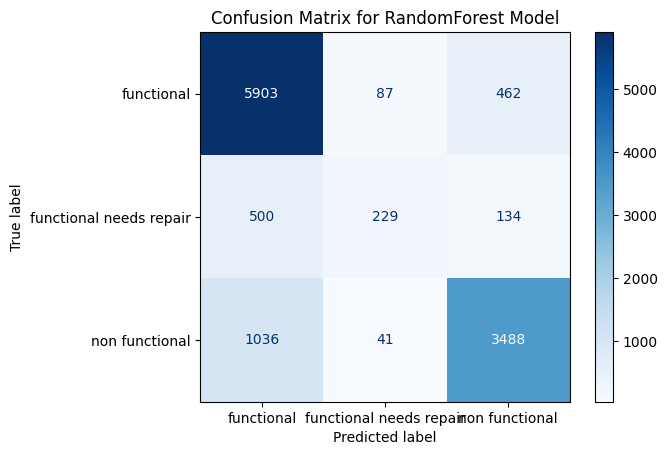

In [ ]:
# Generate confusion matrix
rf_cm = confusion_matrix(y_test, rf_preds)

# Display confusion matrix
rf_disp = ConfusionMatrixDisplay(
    confusion_matrix=rf_cm, display_labels=rf_model.classes_)

rf_disp.plot(cmap='Blues')
plt.title('Confusion Matrix for RandomForest Model')
plt.show()

In [ ]:
# Train on full data before predictions
X_final = pd.concat([X_train_final, X_test_final], axis=0)
y_final = pd.concat([y_train, y_test], axis=0)


rf_model.fit(X_final, y_final)

RandomForestClassifier(criterion='entropy', max_depth=69,
                       max_features=0.7385480758096516, min_samples_leaf=3,
                       min_samples_split=9, n_estimators=250, n_jobs=-1,
                       random_state=42)

# LGBM

In [ ]:
# Convert from 'object' to 'category' dtypes
X_train_cat = X_train.apply(
    lambda col: col.astype('category') if col.dtype == 'object' else col)
X_test_cat = X_test.apply(
    lambda col: col.astype('category') if col.dtype == 'object' else col)
test_features_cat = test_features.apply(
    lambda col: col.astype('category') if col.dtype == 'object' else col)

In [ ]:
# LGBM with Best Hyperparameters
lgbm_best_params = {
    'num_leaves': 59,
    'max_depth': 44,
    'learning_rate': 0.041786677018894554,
    'n_estimators': 824,
    'min_child_samples': 45,
    'subsample': 0.7662423547244932,
    'colsample_bytree': 0.7460637441592799,
    'reg_alpha': 0.001169447139534055,
    'reg_lambda': 0.23281199844208145
}

lgbm_model = LGBMClassifier(
    **lgbm_best_params,
    n_jobs=-1,
    random_state=42,
)

# Try categorical_feature='auto' (similar to CatBoost)
lgbm_model.fit(
    X_train_cat, y_train,
    categorical_feature='auto'
)

lgbm_auto_preds = lgbm_model.predict(X_test_cat)
print(f"Accuracy: {accuracy_score(y_test, lgbm_auto_preds)}")
print("LGBM Classification Report:\n",
      classification_report(y_test, lgbm_auto_preds))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 40
[LightGBM] [Info] Start training from score -0.610505
[LightGBM] [Info] Start training from score -2.621618
[LightGBM] [Info] Start training from score -0.956493
Accuracy: 0.8027777777777778
LGBM Classification Report:
                          precision    recall  f1-score   support

             functional       0.79      0.90      0.84      6452
functional needs repair       0.62      0.29      0.39       863
         non functional       0.84      0.76      0.80      4565

               accuracy                           0.80     11880
              macro avg       0.75      0.65      0.68     11880
           weighted avg       0.80 

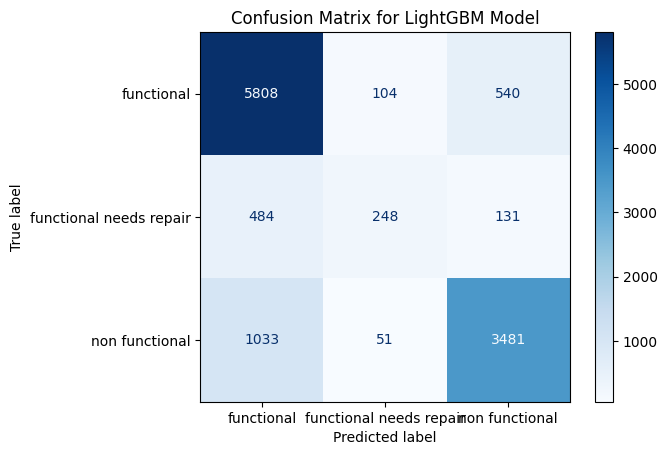

In [ ]:
# Generate confusion matrix
lgbm_cm = confusion_matrix(y_test, lgbm_auto_preds)

# Display confusion matrix
lgbm_disp = ConfusionMatrixDisplay(
    confusion_matrix=lgbm_cm,
    display_labels=lgbm_model.classes_)
lgbm_disp.plot(cmap='Blues')
plt.title('Confusion Matrix for LightGBM Model')
plt.show()

In [ ]:
# Train on full data before predictions
X_final_cat = pd.concat([X_train_cat, X_test_cat], axis=0)

# Convert back to 'category' dtype
X_final_cat = X_final_cat.apply(
    lambda col: col.astype('category') if col.dtype == 'object' else col)

y_final_cat = pd.concat([y_train, y_test], axis=0)

lgbm_model.fit(X_final_cat, y_final_cat)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2451
[LightGBM] [Info] Number of data points in the train set: 59400, number of used features: 40
[LightGBM] [Info] Start training from score -0.610497
[LightGBM] [Info] Start training from score -2.621734
[LightGBM] [Info] Start training from score -0.956482


LGBMClassifier(colsample_bytree=0.7460637441592799,
               learning_rate=0.041786677018894554, max_depth=44,
               min_child_samples=45, n_estimators=824, n_jobs=-1, num_leaves=59,
               random_state=42, reg_alpha=0.001169447139534055,
               reg_lambda=0.23281199844208145, subsample=0.7662423547244932)

# CatBoost

In [ ]:
# Identify categorical feature indices
categorical_features_indices = [
    X.columns.get_loc(col) for col in X.select_dtypes(
        include=['object']).columns]

# Create a Pool
train_pool = Pool(
    X_train, y_train,
    cat_features=categorical_features_indices
)

# Set params
cb_params = {
    'depth': 9,
    #'auto_class_weights': 'Balanced',
    'one_hot_max_size': 200,
    'learning_rate': 0.05,
    'l2_leaf_reg': 4,
    'iterations': 2000,
    'loss_function': 'MultiClass',
    'eval_metric': 'MultiClass',
    'random_seed': 42,
    'logging_level': 'Silent',
    'od_type': 'Iter',
    'od_wait': 50,
    'task_type':'GPU'
}

# Initialize CatBoost model
cb_model = CatBoostClassifier(
    **cb_params
)

# Fit CatBoost model
cb_model.fit(
    train_pool,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Evaluate the best model
cb_preds = cb_model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, cb_preds)}')
print(classification_report(y_test, cb_preds))

Accuracy: 0.8003367003367003
                         precision    recall  f1-score   support

             functional       0.78      0.92      0.84      6452
functional needs repair       0.65      0.25      0.36       863
         non functional       0.85      0.74      0.79      4565

               accuracy                           0.80     11880
              macro avg       0.76      0.63      0.66     11880
           weighted avg       0.80      0.80      0.79     11880



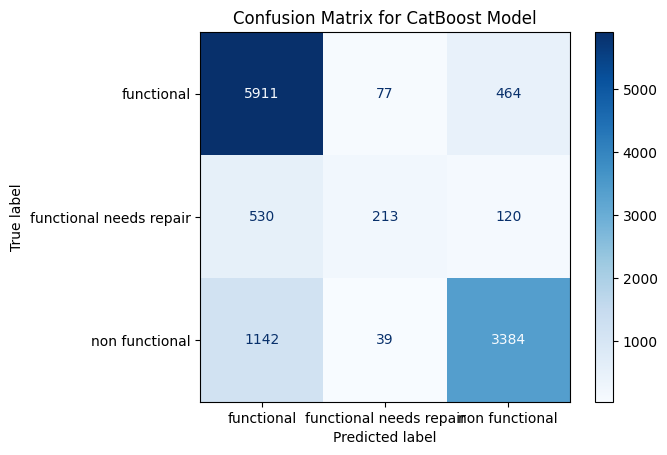

In [ ]:
# Generate confusion matrix
cb_cm = confusion_matrix(y_test, cb_preds)

# Display confusion matrix
cb_disp = ConfusionMatrixDisplay(confusion_matrix=cb_cm,
                              display_labels=cb_model.classes_)
cb_disp.plot(cmap='Blues')
plt.title('Confusion Matrix for CatBoost Model')
plt.show()

In [ ]:
# Train on full data before predictions
X_final_cb = pd.concat([X_train, X_test], axis=0)
y_final_cb = pd.concat([y_train, y_test], axis=0)

cb_model.fit(
    Pool(X_final_cb, y_final_cb, cat_features=categorical_features_indices),
    eval_set=[]
)

# Soft Voting

In [ ]:
# Get predicted probabilities from each model on the 'test_features' dataset
rf_proba = rf_model.predict_proba(test_features_final)
lgbm_proba = lgbm_model.predict_proba(test_features_cat)
cb_proba = cb_model.predict_proba(test_features)

# Define weights based on model performance
weights = np.array([1/3, 1/3, 1/3])  # Weights for RandomForest, LightGBM, CatBoost

# Calculate weighted average of probabilities for soft voting
combined_proba = (rf_proba * weights[0]) + (lgbm_proba * weights[1]) + (cb_proba * weights[2])

# Predict the final class based on the highest probability
final_predictions = np.argmax(combined_proba, axis=1)

# Define the mapping dictionary
label_mapping = {
    0: 'functional',
    1: 'functional needs repair',
    2: 'non functional'
}

# Convert numeric predictions back to original labels
final_labels = np.array([label_mapping[pred] for pred in final_predictions])

In [ ]:
# Replace values in 'status_group' with cbt_test_preds
submission['status_group'] = final_labels

#submission.to_csv('submission_final.csv', index=False)

## Final Competition Score: 0.8212